In [1]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'1.12.1'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [28]:
import shutil
from pathlib import Path

# Setup path to data folder
src_path = Path("../data/images/")
data_path = Path("customdata/")
image_path = data_path / "dashcam"
train_path = image_path / "train"
valid_path = image_path / "valid"
test_path = image_path / "test"

# If the training folder doesn't exist, create it 
if train_path.is_dir():
    print(f"{train_path} directory exists.")
else:
    print(f"Did not find {train_path} directory, creating one...")
    train_path.mkdir(parents=True, exist_ok=True)

# If the validate folder doesn't exist, create it 
if valid_path.is_dir():
    print(f"{valid_path} directory exists.")
else:
    print(f"Did not find {valid_path} directory, creating one...")
    valid_path.mkdir(parents=True, exist_ok=True)

# If the test folder doesn't exist, create it 
if test_path.is_dir():
    print(f"{test_path} directory exists.")
else:
    print(f"Did not find {test_path} directory, creating one...")
    test_path.mkdir(parents=True, exist_ok=True)

img_count = 2040
train_count = int(img_count * .7)
valid_count = int(img_count * .15)
test_count = int(img_count * .15)

# Copy training images
for i in range(train_count):
    filename = src_path / f'flow{i}.jpg'
    shutil.copy(filename,train_path)

# Copy validation images
for i in range(train_count,train_count+valid_count):
    filename = src_path / f'flow{i}.jpg'
    shutil.copy(filename,valid_path)

# Copy testing images
for i in range(train_count+valid_count,train_count+valid_count+test_count):
    filename = src_path / f'flow{i}.jpg'
    shutil.copy(filename,test_path)

print("files copied.")

customdata/dashcam/train directory exists.
customdata/dashcam/valid directory exists.
customdata/dashcam/test directory exists.
files copied.


In [29]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [43]:
walk_through_dir(image_path)

There are 3 directories and 1 images in 'customdata/dashcam'.
There are 0 directories and 306 images in 'customdata/dashcam/valid'.
There are 0 directories and 306 images in 'customdata/dashcam/test'.
There are 0 directories and 1428 images in 'customdata/dashcam/train'.


In [44]:
# Setup train, validate and testing paths
train_dir = image_path / "train"
valid_dir = image_path / "valid"
test_dir = image_path / "test"


train_dir, valid_dir, test_dir

(PosixPath('customdata/dashcam/train'),
 PosixPath('customdata/dashcam/valid'),
 PosixPath('customdata/dashcam/test'))

Random image path: customdata/dashcam/train/flow646.jpg
Image class: train
Image height: 480
Image width: 640


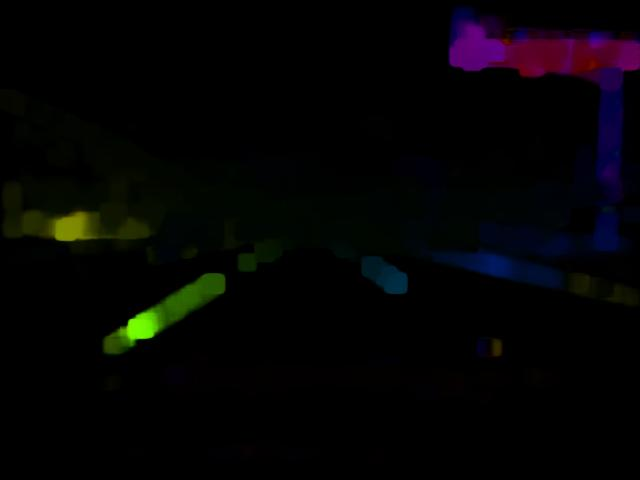

In [33]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

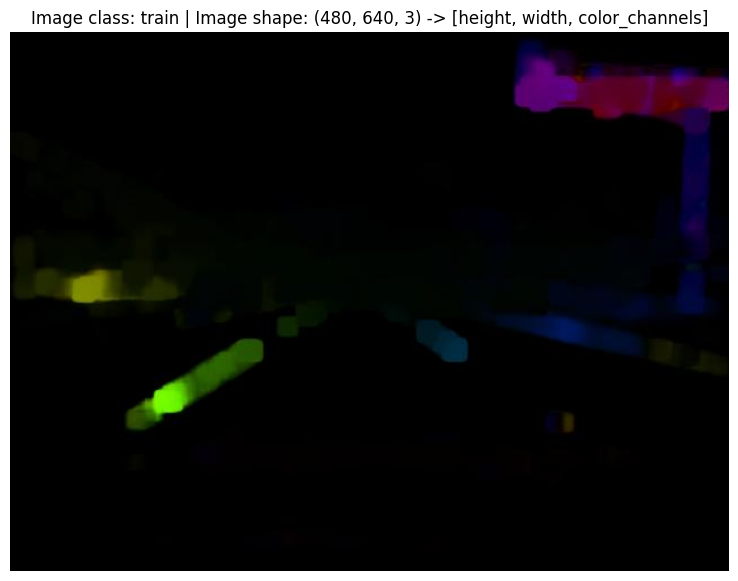

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [46]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [47]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 60x80
    transforms.Resize(size=(60, 80)),
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

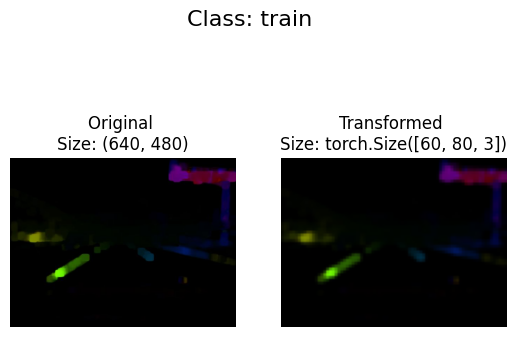

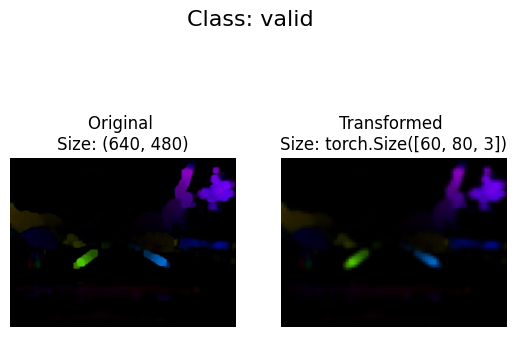

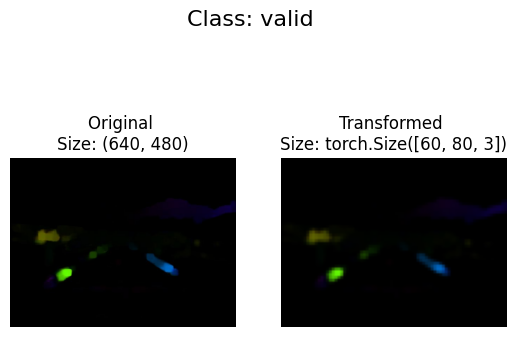

In [48]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

In [60]:
from typing import Dict, Any
from torchvision import datasets


class RegressionImageFolder(datasets.ImageFolder):
    def __init__(
        self, root: str, image_scores: Dict[str, float], **kwargs: Any
    ) -> None:
        super().__init__(root, **kwargs)
        paths, _ = zip(*self.imgs)
        self.targets = [image_scores[path] for path in paths]
        self.samples = self.imgs = list(zip(paths, self.targets))

In [ ]:
train_data = RegressionImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

valid_data = RegressionImageFolder(root=valid_dir, 
                                 transform=data_transform)

test_data = RegressionImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nValidation data:\n{valid}\nTest data:\n{test_data}")